In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from biodata.delimited import DelimitedReader, DelimitedWriter

In [2]:
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/"
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/"

# Input data

In [ ]:
# Download genome files required by ProCapNet

# ! bash $PROJECT_DIR_s/genomes/download_genome_hg38.sh

In [6]:
# Here, we want to evaluate the effects of sequencing depth on binary classification of transcription directionality (divergent vs. unidirectional).
# We train the model using the original dataset (excluding elements that overlap with unidirectional elements called at downsampled datasets) and plot the predicted signals for unidirectional elements called at downsampled datasets.

In [3]:
s = "C1"
p = "unidirectional"
ds = ["distal", "proximal"]

In [ ]:
# Merge all unidirectional elements across different seq depths

samples = [f"{s}_{n}M" for n in [30, 20, 10, 5, 1]]
outputfile = f"{PROJECT_DIR_o}processed/{s}/excluded.bed"
inputfiles = [f"{PROJECT_DIR_d}bed_plot/{sid}_{p}_{d}.bed" for sid in samples for d in ds]
with DelimitedWriter(outputfile) as dw:
	for inputfile in inputfiles:
		with DelimitedReader(inputfile) as dr:
			for cols in dr:
				dw.write(cols[:3])

In [4]:
# No. excluded peaks

! wc -l $PROJECT_DIR_o/processed/$s/excluded.bed

17962 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet//processed/C1/excluded.bed


In [5]:
script = f"{PROJECT_DIR_s}slurm/input.sh"
prefix = "brm_C1a_and_C1b_erm"
dnase = f"{PROJECT_DIR_r}ENCODE/ENCFF185XRG.bed.gz"
sex = "F"
excluded = f"{PROJECT_DIR_o}processed/{s}/excluded.bed"
commands = " ".join(["sbatch", script,
					 PROJECT_DIR_d,
					 prefix,
					 f"{PROJECT_DIR_o}processed/{s}",
					 dnase,
					 sex,
					 excluded
					])
print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/input.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/ brm_C1a_and_C1b_erm /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/processed/C1 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/ENCODE/ENCFF185XRG.bed.gz F /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/processed/C1/excluded.bed


In [6]:
# No. peaks before filtering

! wc -l $PROJECT_DIR_o/processed/$s/temp.peaks.bed

56184 /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet//processed/C1/temp.peaks.bed


In [7]:
# No. peaks after filtering

! zcat $PROJECT_DIR_o/processed/$s/peaks.bed.gz | wc -l

43656


# Train models

In [ ]:
# Set the parameters in "hyperparameter.py"
# self.in_window = 1000
# self.out_window = 500
# source_fracs = [1,0]

In [ ]:
# Due to limited GPU resource, train these models in all available servers 
# check memory availability "check_cuda.sh" in cluster OR "nvidia-smi" in server 01/02 to set cuda parameter; add GPU name at the end (0 or 1 based on availability)

In [8]:
# add gpu at the end

model_type = "strand_merged_umap"
script = f"{PROJECT_DIR_s}slurm/train.sh"
for fold in range(1,8):
	commands = " ".join(["sbatch", script, 
						s,
						model_type,
						PROJECT_DIR_o,
						str(fold)
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 1
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 2
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 3
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 4
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/train.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc255

# Evaluate models

In [9]:
files = glob.glob(f"{PROJECT_DIR_o}models/{s}/{model_type}/*.model")
timestamps = sorted([f.split("/")[-1].split(".model")[0] for f in files])

In [10]:
# Add GPU name at the end
# Only run test sets

script = f"{PROJECT_DIR_s}slurm/eval.sh"
for k in timestamps:
	fold, timestamp = k.split(".") 
	commands = " ".join(["sbatch", script, 
						s,
						model_type,
						PROJECT_DIR_o,
						fold,
						timestamp
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 1 2024-10-22_00-31-24
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 2 2024-10-22_00-33-02
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 3 2024-10-22_00-46-05
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/procapnet/slurm/eval.sh C1 strand_merged_umap /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/procapnet/ 4 2024-10-22_01-00-38
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/softwares/proc

In [11]:
# Check correlation

results = []
for k in timestamps:
	inputfile = f"{PROJECT_DIR_o}model_out/{s}/{model_type}/{k.split('.')[1]}/test_run_log.txt"
	with open(inputfile, "r") as f:
		lines = f.readlines()
		profile = float(lines[-3].strip().split(": ")[1])
		other = float(lines[-2].strip().split(": ")[1])
		results.append([s, profile, "Profile", k.split(".")[0]])
		results.append([s, other, "Counts", k.split(".")[0]])
df = pd.DataFrame(results, columns=["Model", "Corr", "Type", "Fold"])

In [12]:
for t in ["Profile", "Counts"]:
	print(t, 
		  round(np.mean(df[df["Type"]==t]["Corr"]),3), 
		  round(np.std(df[df["Type"]==t]["Corr"]),3)
		 )

Profile 0.52 0.006
Counts 0.774 0.017


([0, 1], [Text(0, 0, 'Profile'), Text(1, 0, 'Counts')])

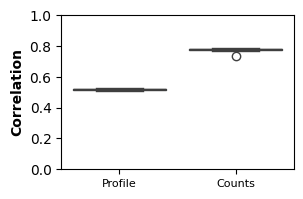

In [13]:
fig, ax = plt.subplots(figsize=(3,2))
g = sns.boxplot(data=df, x="Type", y="Corr", ax=ax)
g.set_ylabel("Correlation", fontsize=10)
g.set_xlabel("")
g.set_ylim([0,1])
plt.xticks(fontsize=8) 